In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n/'
FOLDERNAME = 'cs231n/assignments/assignment1/cs231n/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd cs231n/datasets/
!bash get_datasets.sh
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content
/content/cs231n/datasets
--2020-10-13 14:59:02--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  56.8MB/s    in 2.9s    

2020-10-13 14:59:05 (56.8 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [19]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.377851
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ Since this is the first time loss is calculated after W is initialized, and there are 10 classes, then on average the "chance" probability of 1 class is 1/10. 



In [20]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.706054 analytic: 0.706054, relative error: 9.102097e-08
numerical: 2.593558 analytic: 2.593558, relative error: 3.125121e-08
numerical: -2.293972 analytic: -2.293972, relative error: 9.279757e-09
numerical: 0.434714 analytic: 0.434713, relative error: 2.702927e-07
numerical: 0.198997 analytic: 0.198997, relative error: 5.745052e-07
numerical: -0.277773 analytic: -0.277773, relative error: 2.189060e-07
numerical: 0.681516 analytic: 0.681516, relative error: 9.413831e-09
numerical: 0.337876 analytic: 0.337876, relative error: 2.791269e-07
numerical: 1.472303 analytic: 1.472303, relative error: 5.636129e-08
numerical: -2.208560 analytic: -2.208560, relative error: 4.417398e-09
numerical: -0.395296 analytic: -0.395296, relative error: 6.203015e-08
numerical: -1.222764 analytic: -1.222765, relative error: 5.438949e-08
numerical: -0.068255 analytic: -0.068255, relative error: 9.048490e-07
numerical: 0.877537 analytic: 0.877537, relative error: 1.600207e-08
numerical: -2.671916 a

In [42]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.377851e+00 computed in 0.100718s
vectorized loss: 2.377851e+00 computed in 0.012075s
Loss difference: 0.000000
Gradient difference: 0.000000


In [44]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-5, 1e-4]
regularization_strengths = [2e4, 2.5e4, 3e4, 3.5e4, 4e4, 4.5e4, 5e4, 6e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

def predict_n_evaluate(cls, X, y):
  y_pred = cls.predict(X)
  accuracy = np.mean(y == y_pred)
  return accuracy

for lr in learning_rates:
  for reg in regularization_strengths:
    softmax_cls = Softmax()
    print('learning rate: {}, regularization: {}'.format(lr, reg))
    loss_hist = softmax_cls.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=True)
    train_accuracy = predict_n_evaluate(softmax_cls, X_train, y_train)
    val_accuracy = predict_n_evaluate(softmax_cls, X_val, y_val)
    results[(lr, reg)] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
      best_val = val_accuracy
      best_softmax = softmax_cls
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning rate: 1e-09, regularization: 20000.0
iteration 0 / 1500: loss 613.127419
iteration 100 / 1500: loss 608.147389
iteration 200 / 1500: loss 603.394155
iteration 300 / 1500: loss 598.567419
iteration 400 / 1500: loss 593.352483
iteration 500 / 1500: loss 589.475672
iteration 600 / 1500: loss 584.300505
iteration 700 / 1500: loss 579.638814
iteration 800 / 1500: loss 574.858313
iteration 900 / 1500: loss 570.860146
iteration 1000 / 1500: loss 565.823971
iteration 1100 / 1500: loss 561.454114
iteration 1200 / 1500: loss 557.293743
iteration 1300 / 1500: loss 552.553244
iteration 1400 / 1500: loss 548.106899
learning rate: 1e-09, regularization: 25000.0
iteration 0 / 1500: loss 767.075692
iteration 100 / 1500: loss 759.695632
iteration 200 / 1500: loss 752.278260
iteration 300 / 1500: loss 744.429563
iteration 400 / 1500: loss 737.208519
iteration 500 / 1500: loss 729.609912
iteration 600 / 1500: loss 722.723891
iteration 700 / 1500: loss 715.548653
iteration 800 / 1500: loss 708.47

/content/cs231n/classifiers/softmax.py:81: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(softmax[np.arange(num_train),y]).sum()


iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf


/content/cs231n/classifiers/softmax.py:83: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/cs231n/classifiers/softmax.py:83: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf


/content/cs231n/classifiers/softmax.py:79: RuntimeWarning: overflow encountered in subtract
  scores -= np.max(scores, axis=1, keepdims=True)  # avoid numerical instability
/content/cs231n/classifiers/softmax.py:79: RuntimeWarning: invalid value encountered in subtract
  scores -= np.max(scores, axis=1, keepdims=True)  # avoid numerical instability
/content/cs231n/classifiers/softmax.py:87: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W


iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
learning rate: 0.0001, regularization: 25000.0
iteration 0 / 1500: loss 783.255760
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
learning rate: 0.0001, regularization: 30000.0
iteration 0 / 1500: loss 915.456043
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 15

In [45]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.349000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True


$\color{blue}{\textit Your Explanation:}$ A new datapoint will not increase the SVM loss (i.e., hinge-loss will yield zero) when the correct score is larger than any other class score + the margin. If this condition is met, than the datapoint will add zero to the overall loss. However, with softmax loss, the loss is calculated by -log(prob) of the correct class. Even if the correct class is substantially larger than the other classes, it will still add something to the overall loss. 



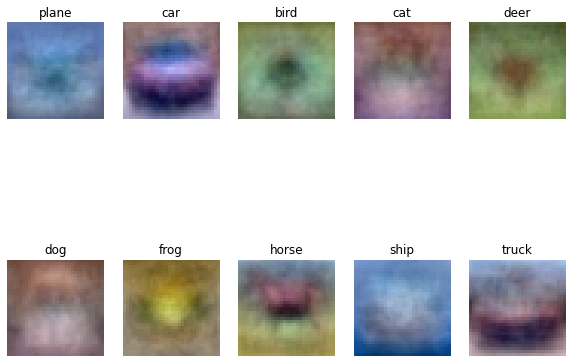

In [46]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [47]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = ['cs231n/classifiers/softmax.py']

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))